# BERT-based Part-of-Speech Tagging (PyTorch)

- **Goal**: Implement POS tagging using BERT
- **Data**: NLTK Penn Treebank for training (English), **CORD-19** for inference/application
- **Framework**: PyTorch + Hugging Face Transformers

## 1. Introduction & Experimental Setup

In [3]:
import os
import platform
import random
import re
from collections import Counter

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForTokenClassification, get_linear_schedule_with_warmup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

pd.options.display.float_format = "{:.4f}".format

CSV_ENCODINGS = ("utf-8", "utf-8-sig", "cp949", "latin1")
METADATA_CSV_PATH = os.path.join(os.getcwd(), "dataset", "metadata.csv")
METADATA_USECOLS = ["cord_uid", "title", "abstract"]

print(f"PyTorch: {torch.__version__}, CUDA: {torch.cuda.is_available()}")

PyTorch: 2.7.1+cu118, CUDA: True


In [4]:

setup_rows = [
    ("task", "POS tagging (PTB training) + CORD-19 inference"),
    ("dataset_train", "NLTK Penn Treebank tagged_sents"),
    ("dataset_inference", "CORD-19 metadata abstract samples"),
    ("split", "70/10/20 (train/dev/test)"),
    ("model_name", globals().get("MODEL_NAME", "bert-base-cased")),
    ("max_len", globals().get("MAX_LEN", 160)),
    ("batch_size", globals().get("BATCH_SIZE", 16)),
    ("epochs", globals().get("EPOCHS", 5)),
    ("learning_rate", globals().get("LR", 3e-5)),
    ("optimizer", "AdamW"),
    ("scheduler", "linear warmup/decay"),
    ("python", platform.python_version()),
    ("torch", torch.__version__),
    ("cuda_available", torch.cuda.is_available()),
    ("cuda_device_count", torch.cuda.device_count() if torch.cuda.is_available() else 0),
    ("cuda_device_name", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"),
    ("os", f"{platform.system()} {platform.release()}"),
]

setup_df = pd.DataFrame(setup_rows, columns=["item", "value"])
display(setup_df)

,item,value
0,task,POS tagging (PTB training) + CORD-19 inference
1,dataset_train,NLTK Penn Treebank tagged_sents
2,dataset_inference,CORD-19 metadata abstract samples
3,split,70/10/20 (train/dev/test)
4,model_name,bert-base-cased
5,max_len,160
6,batch_size,16
7,epochs,5
8,learning_rate,0.0000
9,optimizer,AdamW


### 1.1 Objective and Data

- Objective: Apply a POS tagger trained on PTB to CORD-19
- Training data: NLTK Penn Treebank
- Application data: CORD-19 abstracts

Since CORD-19 has no gold POS labels, this part is treated as inference/analysis rather than supervised evaluation.

In [ ]:
nltk.download("treebank")

tagged_sents = nltk.corpus.treebank.tagged_sents()

all_tokens = []
all_tag_strings = []
for sent in tagged_sents:
    tokens = [w for w, t in sent]
    tags = [t for w, t in sent]
    all_tokens.append(tokens)
    all_tag_strings.append(tags)

label_names = sorted({tag for tags in all_tag_strings for tag in tags})
id2label = {i: tag for i, tag in enumerate(label_names)}
label2id = {tag: i for i, tag in enumerate(label_names)}
num_labels = len(label_names)

indices = list(range(len(all_tokens)))
train_dev_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
train_idx, dev_idx = train_test_split(train_dev_idx, test_size=0.125, random_state=42)

train_data = [
    {
        "tokens": all_tokens[i],
        "pos_tags": [label2id[t] for t in all_tag_strings[i]],
    }
    for i in train_idx
]

dev_data = [
    {
        "tokens": all_tokens[i],
        "pos_tags": [label2id[t] for t in all_tag_strings[i]],
    }
    for i in dev_idx
]

test_data = [
    {
        "tokens": all_tokens[i],
        "pos_tags": [label2id[t] for t in all_tag_strings[i]],
    }
    for i in test_idx
]

total_n = len(indices)
print("POS labels count:", num_labels)
print(f"Split sizes -> train: {len(train_data)}, dev: {len(dev_data)}, test: {len(test_data)}")
print(f"Split ratios -> train: {len(train_data)/total_n:.4f}, dev: {len(dev_data)/total_n:.4f}, test: {len(test_data)/total_n:.4f}")
print("Sample sentence:", train_data[0]["tokens"][:15])
print("Sample POS:", [id2label[i] for i in train_data[0]["pos_tags"][:15]])

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\syoon\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


POS labels count: 46
Split sizes -> train: 2739, dev: 392, test: 783
Split ratios -> train: 0.700, dev: 0.100, test: 0.200
Sample sentence: ['Some', 'Democrats', ',', 'led', '*', 'by', 'Rep.', 'Jack', 'Brooks', '-LRB-', 'D.', ',', 'Texas', '-RRB-', ',']
Sample POS: ['RB', 'NNPS', ',', 'VBN', '-NONE-', 'IN', 'NNP', 'NNP', 'NNP', '-LRB-', 'NNP', ',', 'NNP', '-RRB-', ',']


### 1.2 Model Architecture: BERT Token Classification

Because BERT operates at subword level, word-level labels are aligned to subwords.
Only the first subword of each word gets a label; the rest are masked with `-100`.

In [4]:
MODEL_NAME = "bert-base-cased"
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)

def align_labels_to_tokens(labels, word_ids):
    """Align labels to subwords: label first subword only, mask others with -100."""
    aligned = []
    prev_id = None
    for wid in word_ids:
        if wid is None:  
            aligned.append(-100)
        elif wid != prev_id:
            aligned.append(labels[wid])
        else:
            aligned.append(-100)
        prev_id = wid
    return aligned

### 1.3 Dataset & DataLoader

In [5]:
class POSDataset(Dataset):
    def __init__(self, data, tokenizer, label2id, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        item = self.data[i]
        tokens = item["tokens"]
        labels = item["pos_tags"]  
        encoding = self.tokenizer(
            tokens,
            is_split_into_words=True,
            return_offsets_mapping=True,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        word_ids = encoding.word_ids()
        aligned_labels = align_labels_to_tokens(labels, word_ids)
        encoding["labels"] = torch.tensor(aligned_labels, dtype=torch.long)

        del encoding["offset_mapping"]
        return {k: v.squeeze(0) for k, v in encoding.items()}

MAX_LEN = 160
BATCH_SIZE = 16
train_dataset = POSDataset(train_data, tokenizer, label2id, max_length=MAX_LEN)
dev_dataset = POSDataset(dev_data, tokenizer, label2id, max_length=MAX_LEN)
test_dataset = POSDataset(test_data, tokenizer, label2id, max_length=MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"Dataloader batches -> train: {len(train_loader)}, dev: {len(dev_loader)}, test: {len(test_loader)}")

Dataloader batches -> train: 172, dev: 25, test: 49


### 1.4 Model Initialization

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)
model.to(device)

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForTokenClassification LOAD REPORT from: bert-base-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
bert.pooler.dense.weight                   | UNEXPECTED | 
bert.pooler.dense.bias                     | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized beca

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

### 1.5 Training Configuration & Loop

In [7]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

EPOCHS = 5
LR = 3e-5
WEIGHT_DECAY = 0.01

total_steps = len(train_loader) * EPOCHS
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=total_steps // 10,
    num_training_steps=total_steps,
)

best_dev_acc = 0.0
best_state_dict = None

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} (train)")
    for batch in pbar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        pbar.set_postfix(loss=loss.item())

    train_loss = total_loss / len(train_loader)

    model.eval()
    dev_preds, dev_labels = [], []
    with torch.no_grad():
        for batch in tqdm(dev_loader, desc=f"Epoch {epoch+1}/{EPOCHS} (dev)"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"]

            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
            preds = logits.argmax(-1).cpu()
            mask = labels != -100
            dev_preds.extend(preds[mask].numpy())
            dev_labels.extend(labels[mask].numpy())

    dev_acc = (np.array(dev_preds) == np.array(dev_labels)).mean()

    if dev_acc > best_dev_acc:
        best_dev_acc = dev_acc
        best_state_dict = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    print(f"Epoch {epoch+1} train loss: {train_loss:.4f} | dev acc: {dev_acc:.4f}")

if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    model.to(device)
print(f"Best dev accuracy: {best_dev_acc:.4f}")

Epoch 1/5 (dev): 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Epoch 1 train loss: 1.3822 | dev acc: 0.9725


Epoch 2/5 (dev): 100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


Epoch 2 train loss: 0.0942 | dev acc: 0.9772


Epoch 3/5 (dev): 100%|██████████| 25/25 [00:10<00:00,  2.38it/s]


Epoch 3 train loss: 0.0550 | dev acc: 0.9794


Epoch 4/5 (dev): 100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Epoch 4 train loss: 0.0372 | dev acc: 0.9792


Epoch 5/5 (dev): 100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Epoch 5 train loss: 0.0281 | dev acc: 0.9803
Best dev accuracy: 0.9803


## 2. PTB Evaluation (In-domain Performance)

In [13]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"]
        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
        preds = logits.argmax(-1).cpu()
        mask = labels != -100
        all_preds.extend(preds[mask].numpy())
        all_labels.extend(labels[mask].numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"Token-level accuracy: {acc:.4f}")

label_ids = sorted(id2label.keys())
label_names = [id2label[i] for i in label_ids]

report = classification_report(
    all_labels,
    all_preds,
    labels=label_ids,
    target_names=label_names,
    output_dict=True,
    zero_division=0,
)
report_df = pd.DataFrame(report).T.round(4)

print("\n[Per-tag classification report]")
display(
    report_df.loc[label_names + ["accuracy", "macro avg", "weighted avg"],
                  ["precision", "recall", "f1-score", "support"]]
)

Evaluating:   0%|          | 0/49 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 49/49 [00:22<00:00,  2.17it/s]

Token-level accuracy: 0.9817

[Per-tag classification report]


,precision,recall,f1-score,support
#,1.0000,1.0000,1.0000,1.0000
$,1.0000,1.0000,1.0000,174.0000
'',1.0000,1.0000,1.0000,132.0000
",",1.0000,1.0000,1.0000,985.0000
-LRB-,0.9444,1.0000,0.9714,17.0000
-NONE-,0.9993,1.0000,0.9996,1352.0000
-RRB-,1.0000,1.0000,1.0000,20.0000
.,0.9987,1.0000,0.9994,775.0000
:,1.0000,0.9901,0.9950,101.0000
CC,0.9916,1.0000,0.9958,471.0000


## 3. Cross-Domain Inference on CORD-19

Because CORD-19 does not include gold POS labels, this section is **inference-based analysis**.

- Raw CORD-19 prediction results
- Full-token level analysis
- Confidence distribution

In [ ]:
def _read_csv_with_fallback(path):
    for enc in CSV_ENCODINGS:
        try:
            return pd.read_csv(path, encoding=enc, usecols=METADATA_USECOLS, low_memory=True)
        except (UnicodeDecodeError, pd.errors.ParserError, MemoryError):
            continue
        except ValueError:
            return pd.read_csv(path, encoding=enc, low_memory=True)

    return pd.read_csv(
        path,
        encoding="utf-8",
        encoding_errors="replace",
        usecols=METADATA_USECOLS,
        engine="python",
    )


metadata_csv = METADATA_CSV_PATH
print("Using metadata:", metadata_csv)

if os.path.exists(metadata_csv):
    metadata_df = _read_csv_with_fallback(metadata_csv)
    print("metadata rows:", len(metadata_df))
    show_cols = [c for c in ["cord_uid", "title", "abstract"] if c in metadata_df.columns]
    if show_cols:
        print(metadata_df[show_cols].head(3))
    else:
        print("metadata columns sample:", list(metadata_df.columns[:10]))
else:
    metadata_df = None
    print("metadata.csv not found at:", metadata_csv)
    print("Please place the file at dataset/metadata.csv")

Using metadata: d:\BERT\dataset\metadata.csv
metadata rows: 1056660
   cord_uid                                              title  \
0  ug7v899j  Clinical features of culture-proven Mycoplasma...   
1  02tnwd4m  Nitric oxide: a pro-inflammatory mediator in l...   
2  ejv2xln0    Surfactant protein-D and pulmonary host defense   

                                            abstract  
0  OBJECTIVE: This retrospective chart review des...  
1  Inflammatory diseases of the respiratory tract...  
2  Surfactant protein-D (SP-D) participates in th...  


In [ ]:
def predict_pos(sentences, model, tokenizer, id2label, device, max_length=128):
    model.eval()
    results = []
    for words in sentences:
        if not words:
            results.append([])
            continue
        encoding = tokenizer(
            words,
            is_split_into_words=True,
            return_offsets_mapping=False,
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        word_ids = encoding.word_ids()
        with torch.no_grad():
            logits = model(
                input_ids=encoding["input_ids"].to(device),
                attention_mask=encoding["attention_mask"].to(device),
            ).logits
        pred_ids = logits[0].argmax(-1).cpu().tolist()

        prev_id = None
        word_tags = []
        for idx, wid in enumerate(word_ids):
            if wid is not None and wid != prev_id:
                word_tags.append(id2label.get(pred_ids[idx], "X"))
            prev_id = wid
        results.append(word_tags)
    return results

In [ ]:
if metadata_df is not None and len(metadata_df) > 0:
    sample_rows = metadata_df[metadata_df["abstract"].notna() & (metadata_df["abstract"].str.len() > 0)]
    if len(sample_rows) > 0:
        text = sample_rows.iloc[0]["abstract"]
        words = str(text).split()[:30]  
        pred_tags = predict_pos([words], model, tokenizer, id2label, device)
        print("Token -> Predicted POS:")
        for w, t in zip(words, pred_tags[0]):
            print(f"  {w}: {t}")
    else:
        print("No usable abstract found in metadata.csv.")
else:
    demo_sent = "The coronavirus pandemic affected global health and economy .".split()
    pred_tags = predict_pos([demo_sent], model, tokenizer, id2label, device)
    print("Demo - Token -> Predicted POS:")
    for w, t in zip(demo_sent, pred_tags[0]):
        print(f"  {w}: {t}")

Token -> Predicted POS:
  OBJECTIVE:: NNP
  This: DT
  retrospective: JJ
  chart: NN
  review: NN
  describes: VBZ
  the: DT
  epidemiology: NN
  and: CC
  clinical: JJ
  features: NNS
  of: IN
  40: CD
  patients: NNS
  with: IN
  culture-proven: JJ
  Mycoplasma: NNP
  pneumoniae: NN
  infections: NNS
  at: IN
  King: NNP
  Abdulaziz: NNP
  University: NNP
  Hospital,: NNP
  Jeddah,: NNP
  Saudi: NNP
  Arabia.: NNP
  METHODS:: NNP
  Patients: NNS
  with: IN


## 4 Raw CORD-19 Results and Full-Token Analysis

Inspect prediction distribution and confidence on full CORD-19 tokens (before filtering).

In [ ]:
if metadata_df is None or len(metadata_df) == 0 or "abstract" not in metadata_df.columns:
    print("metadata_df is missing or has no abstract column. Please run the CORD-19 loading cell first.")
else:

    fast_mode = True
    sample_size = 20000       
    max_words_per_abs = 60  

    valid_df = metadata_df[metadata_df["abstract"].notna() & (metadata_df["abstract"].astype(str).str.len() > 0)].copy()

    if fast_mode:
        work_df = valid_df.sample(n=min(sample_size, len(valid_df)), random_state=42)
        full_sentences = [str(t).split()[:max_words_per_abs] for t in work_df["abstract"].tolist()]
    else:
        work_df = valid_df
        full_sentences = [str(t).split() for t in work_df["abstract"].tolist()]

    def norm_word(w):
        return re.sub(r"^[^a-z0-9]+|[^a-z0-9]+$", "", str(w).lower())

    def predict_pos_with_conf(sentences, model, tokenizer, id2label, device, max_length=128):
        model.eval()
        out_tags, out_conf = [], []
        for words in sentences:
            if not words:
                out_tags.append([])
                out_conf.append([])
                continue

            encoding = tokenizer(
                words,
                is_split_into_words=True,
                return_offsets_mapping=False,
                max_length=max_length,
                padding="max_length",
                truncation=True,
                return_tensors="pt",
            )
            word_ids = encoding.word_ids()

            with torch.no_grad():
                logits = model(
                    input_ids=encoding["input_ids"].to(device),
                    attention_mask=encoding["attention_mask"].to(device),
                ).logits[0].cpu()

            probs = torch.softmax(logits, dim=-1)
            pred_ids = logits.argmax(-1).tolist()
            max_probs = probs.max(dim=-1).values.tolist()

            prev_id = None
            tags, confs = [], []
            for idx, wid in enumerate(word_ids):
                if wid is not None and wid != prev_id:
                    tags.append(id2label.get(pred_ids[idx], "X"))
                    confs.append(float(max_probs[idx]))
                prev_id = wid

            out_tags.append(tags)
            out_conf.append(confs)

        return out_tags, out_conf

    full_tags, full_conf = predict_pos_with_conf(
        full_sentences, model, tokenizer, id2label, device, max_length=MAX_LEN
    )

    rows = []
    for doc_id, (sent, tags, confs) in enumerate(zip(full_sentences, full_tags, full_conf)):
        n = min(len(sent), len(tags), len(confs))
        for i in range(n):
            token_norm = norm_word(sent[i])
            filter_key = token_norm if token_norm else str(sent[i]).lower()
            rows.append({
                "doc_id": doc_id,
                "orig_idx": i,
                "token": sent[i],
                "token_norm": token_norm,
                "filter_key": filter_key,
                "pred_tag": tags[i],
                "conf": confs[i],
            })

    cord_full_df = pd.DataFrame(rows)

    def tag_entropy(tags):
        p = pd.Series(tags).value_counts(normalize=True)
        return float(-(p * np.log2(p + 1e-12)).sum()) if len(p) > 0 else np.nan

    eval_full = pd.DataFrame([{
        "dataset": "A_full",
        "tokens": len(cord_full_df),
        "vocab_size": int(cord_full_df["filter_key"].nunique()),
        "avg_conf": float(cord_full_df["conf"].mean()),
        "tag_entropy": tag_entropy(cord_full_df["pred_tag"]),
    }])

    print(f"[Section 4 Evaluation table - full tokens (fast_mode={fast_mode}, docs={len(full_sentences)})]")
    display(eval_full.style.format({"avg_conf": "{:.4f}", "tag_entropy": "{:.4f}"}))

    print("\n[20 example token-tag pairs]")
    display(cord_full_df.head(20))

    per_doc_full = cord_full_df.groupby("doc_id").agg(
        token_count=("token", "size"),
        unique_tag_count=("pred_tag", "nunique"),
    ).reset_index()

    from collections import Counter
    from sklearn.metrics import classification_report

    if "all_preds" not in globals() or "all_labels" not in globals() or len(all_preds) == 0:
        all_preds, all_labels = [], []
        model.eval()
        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Evaluating (rebuild for F1 plot)"):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"]
                logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
                preds = logits.argmax(-1).cpu()
                mask = labels != -100
                all_preds.extend(preds[mask].numpy().tolist())
                all_labels.extend(labels[mask].numpy().tolist())

    label_ids = sorted(id2label.keys())
    label_names = [id2label[i] for i in label_ids]

    report_dict = classification_report(
        all_labels,
        all_preds,
        labels=label_ids,
        target_names=label_names,
        output_dict=True,
        zero_division=0,
    )
    report_df = pd.DataFrame(report_dict).T
    per_tag_df = report_df.loc[label_names, ["f1-score"]].copy()

    true_counts = Counter(all_labels)
    top_n = 12
    top_label_ids = [lid for lid, _ in true_counts.most_common(top_n)]
    top_tag_names = [id2label[lid] for lid in top_label_ids]
    top_f1 = per_tag_df.loc[top_tag_names, "f1-score"].sort_values(ascending=False)


[Section 4 Evaluation table - full tokens (fast_mode=True, docs=20000)]


,dataset,tokens,vocab_size,avg_conf,tag_entropy
0,A_full,1180376,55628,0.9621,3.7477



[20 example token-tag pairs]


,doc_id,orig_idx,token,token_norm,filter_key,pred_tag,conf
0,0,0,OBJECTIVE:,objective,objective,NNP,0.9751
1,0,1,To,to,to,TO,0.9976
2,0,2,investigate,investigate,investigate,VB,0.9981
3,0,3,the,the,the,DT,0.9989
4,0,4,maternal,maternal,maternal,JJ,0.9963
5,0,5,and,and,and,CC,0.9973
6,0,6,infant,infant,infant,NN,0.9771
7,0,7,outcomes,outcomes,outcomes,NNS,0.9986
8,0,8,of,of,of,IN,0.9993
9,0,9,full-term,full-term,full-term,JJ,0.9979


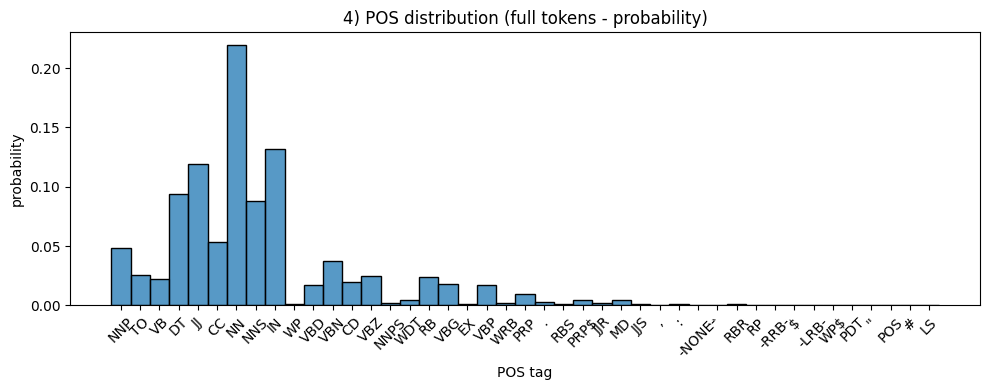

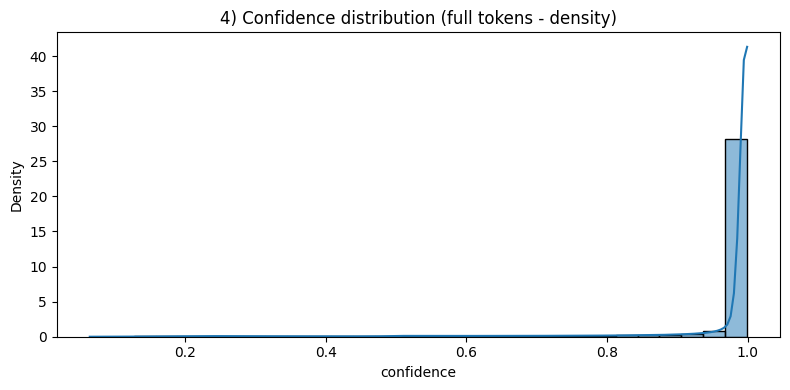

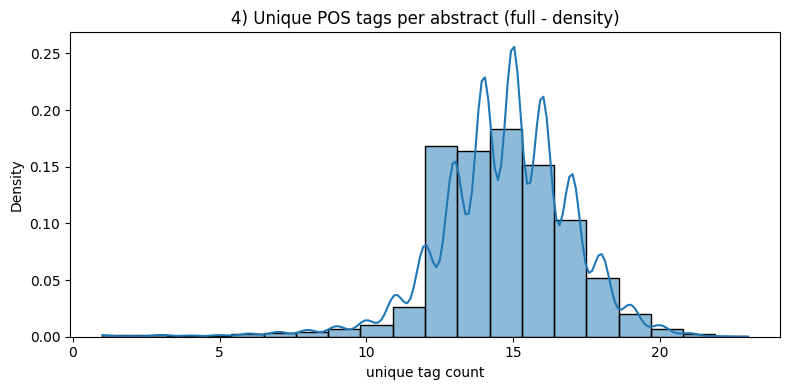

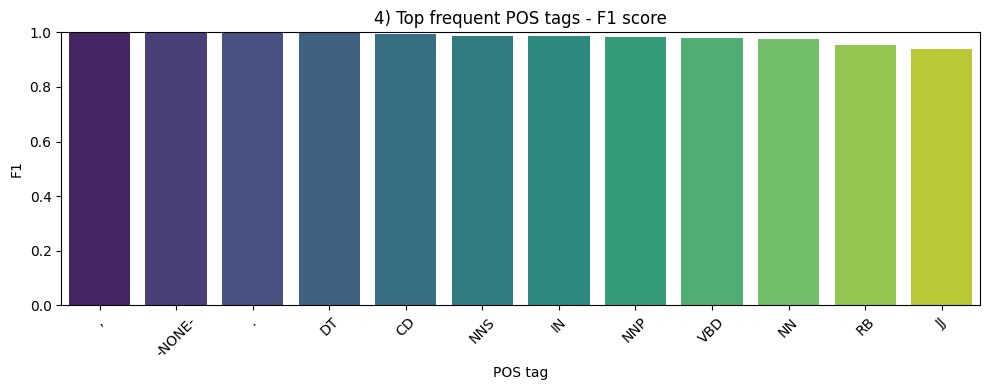

In [ ]:
if "cord_full_df" not in globals() or len(cord_full_df) == 0:
    print("Please run Section 4 calculation cell first.")
else:
    plt.figure(figsize=(10, 4))
    sns.histplot(
        cord_full_df["pred_tag"],
        stat="probability",
        discrete=True
    )
    plt.title("4) POS distribution (full tokens - probability)")
    plt.xlabel("POS tag")
    plt.ylabel("probability")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    sns.histplot(
        cord_full_df["conf"],
        bins=30,
        stat="density",
        kde=True
    )
    plt.title("4) Confidence distribution (full tokens - density)")
    plt.xlabel("confidence")
    plt.tight_layout()
    plt.show()

    if "per_doc_full" in globals() and len(per_doc_full) > 0:
        plt.figure(figsize=(8, 4))
        sns.histplot(
            per_doc_full["unique_tag_count"],
            bins=20,
            stat="density",
            kde=True
        )
        plt.title("4) Unique POS tags per abstract (full - density)")
        plt.xlabel("unique tag count")
        plt.tight_layout()
        plt.show()

    if "top_f1" in globals() and len(top_f1) > 0:
        plt.figure(figsize=(10, 4))
        sns.barplot(x=top_f1.index, y=top_f1.values, hue=top_f1.index, legend=False, palette="viridis")
        plt.title("4) Top frequent POS tags - F1 score")
        plt.ylabel("F1")
        plt.xlabel("POS tag")
        plt.ylim(0, 1.0)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

### 4.1 Effect of Frequency Filtering

Analyze how token-frequency-based filtering changes the results.

- Filtering rule description
- Filtered results
- Raw vs Filtered comparison
- Entropy / Confidence changes

Apply token-frequency filtering to the full-token predictions from Section 9.

- Evaluation table: tokens, vocab size, avg confidence, low-confidence rate, tag entropy
- Plots: POS distribution, confidence distribution, unique tags per document

Then inspect tag-level behavior in more detail on the filtered set.

- Tag table: only tags with support >= 50
- Plot: bottom-10 tags by F1
- Plot: normalized confusion matrix (high-frequency tags)

In [36]:
if "cord_full_df" not in globals() or len(cord_full_df) == 0:
    print("Please run Section 4 first to create full-token predictions (cord_full_df).")
else:
    min_token_freq = 10
    max_token_ratio = 0.01
    low_conf_threshold = 0.60

    token_counts = cord_full_df["filter_key"].value_counts()
    max_token_freq = max(1, int(len(cord_full_df) * max_token_ratio))
    keep_tokens = token_counts[(token_counts >= min_token_freq) & (token_counts <= max_token_freq)].index

    cord_filt_df = cord_full_df[cord_full_df["filter_key"].isin(keep_tokens)].copy()

    def tag_entropy(tags):
        p = pd.Series(tags).value_counts(normalize=True)
        return float(-(p * np.log2(p + 1e-12)).sum()) if len(p) > 0 else np.nan

    eval_filt = pd.DataFrame([{
        "dataset": "B_filtered",
        "tokens": len(cord_filt_df),
        "vocab_size": int(cord_filt_df["filter_key"].nunique()),
        "avg_conf": float(cord_filt_df["conf"].mean()) if len(cord_filt_df) > 0 else np.nan,
        "low_conf_rate": float((cord_filt_df["conf"] < low_conf_threshold).mean()) if len(cord_filt_df) > 0 else np.nan,
        "tag_entropy": tag_entropy(cord_filt_df["pred_tag"]) if len(cord_filt_df) > 0 else np.nan,
    }])

    print("[Section 4-1 Evaluation table - filtered dataset]")
    display(eval_filt.style.format({"avg_conf": "{:.4f}", "low_conf_rate": "{:.4f}", "tag_entropy": "{:.4f}"}))
    print(f"filter params: min_token_freq={min_token_freq}, max_token_ratio={max_token_ratio}, max_token_freq={max_token_freq}")

    if len(cord_filt_df) == 0:
        print("Filtered result is empty.")
    else:
        print("\n[20 example token-tag pairs after filtering]")
        display(cord_filt_df.head(20))

        per_doc_filt = cord_filt_df.groupby("doc_id").agg(
            token_count=("token", "size"),
            unique_tag_count=("pred_tag", "nunique"),
        ).reset_index()


[Section 4-1 Evaluation table - filtered dataset]


,dataset,tokens,vocab_size,avg_conf,low_conf_rate,tag_entropy
0,B_filtered,812310,7626,0.9661,0.0297,3.6194


filter params: min_token_freq=10, max_token_ratio=0.01, max_token_freq=11803

[20 example token-tag pairs after filtering]


,doc_id,orig_idx,token,token_norm,filter_key,pred_tag,conf
0,0,0,OBJECTIVE:,objective,objective,NNP,0.9751
2,0,2,investigate,investigate,investigate,VB,0.9981
4,0,4,maternal,maternal,maternal,JJ,0.9963
6,0,6,infant,infant,infant,NN,0.9771
7,0,7,outcomes,outcomes,outcomes,NNS,0.9986
10,0,10,pregnant,pregnant,pregnant,JJ,0.9810
11,0,11,patients,patients,patients,NNS,0.9985
13,0,13,"Wuhan,",wuhan,wuhan,NNP,0.9870
14,0,14,"China,",china,china,NNP,0.9946
15,0,15,who,who,who,WP,0.9447


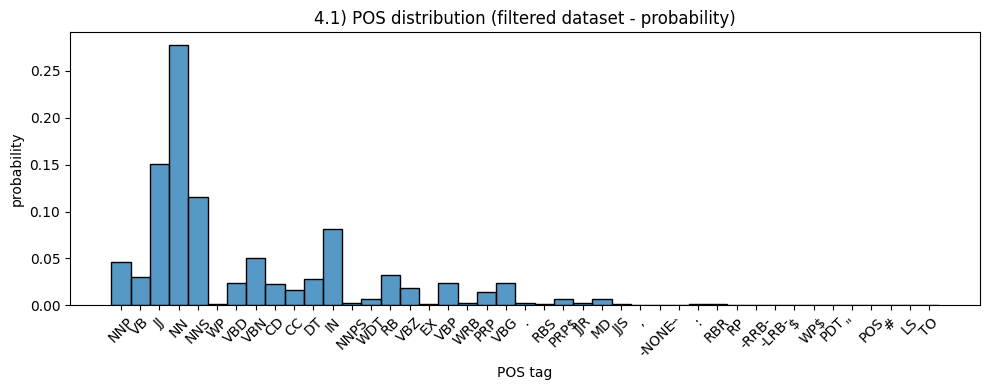

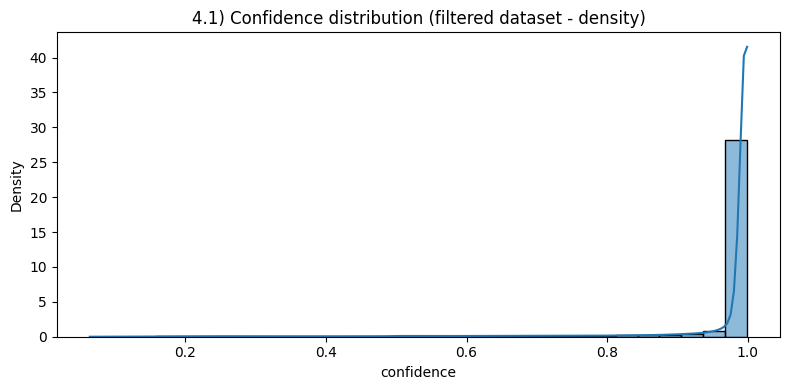

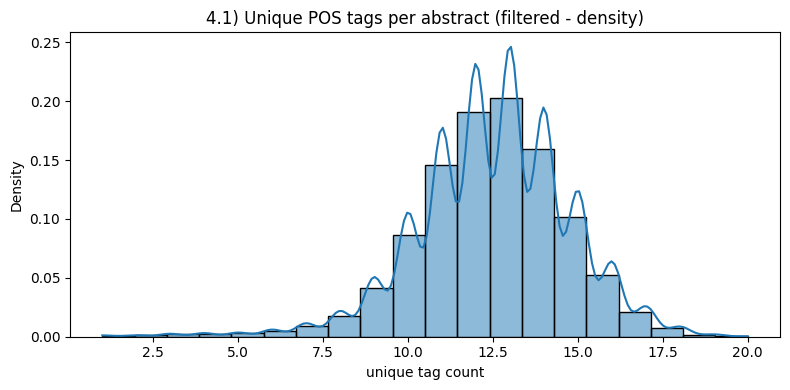

In [ ]:
if "cord_filt_df" not in globals() or len(cord_filt_df) == 0:
    print("Please run Section 4.1 calculation cell first.")
else:
    plt.figure(figsize=(10, 4))
    sns.histplot(
        cord_filt_df["pred_tag"],
        stat="probability",
        discrete=True
    )
    plt.title("4.1) POS distribution (filtered dataset - probability)")
    plt.xlabel("POS tag")
    plt.ylabel("probability")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    sns.histplot(
        cord_filt_df["conf"],
        bins=30,
        stat="density",
        kde=True
    )
    plt.title("4.1) Confidence distribution (filtered dataset - density)")
    plt.xlabel("confidence")
    plt.tight_layout()
    plt.show()

    if "per_doc_filt" in globals() and len(per_doc_filt) > 0:
        plt.figure(figsize=(8, 4))
        sns.histplot(
            per_doc_filt["unique_tag_count"],
            bins=20,
            stat="density",
            kde=True
        )
        plt.title("4.1) Unique POS tags per abstract (filtered - density)")
        plt.xlabel("unique tag count")
        plt.tight_layout()
        plt.show()

### 4.2 PTB Core Performance Summary

Summarize PTB-test accuracy/F1 and per-tag performance.

Provide a final comparison between full-token predictions (Section 9) and filtered predictions (Section 10).

- Final evaluation table
- Confusion matrix (full vs filtered, aligned common tokens)
- Comparison summary (agreement / low-confidence rate)

<>:1: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
C:\Users\syoon\AppData\Local\Temp\ipykernel_3576\3495862879.py:1: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if "cord_full_df" not in globals() or "cord_full_df" is None or len(cord_full_df) == 0:


[Section 11 Final evaluation table]


,dataset,tokens,vocab_size,avg_conf,low_conf_rate,tag_entropy
0,A_full,1180376,55628,0.9621,0.0357,3.7477
1,B_filtered,812310,7626,0.9661,0.0297,3.6194


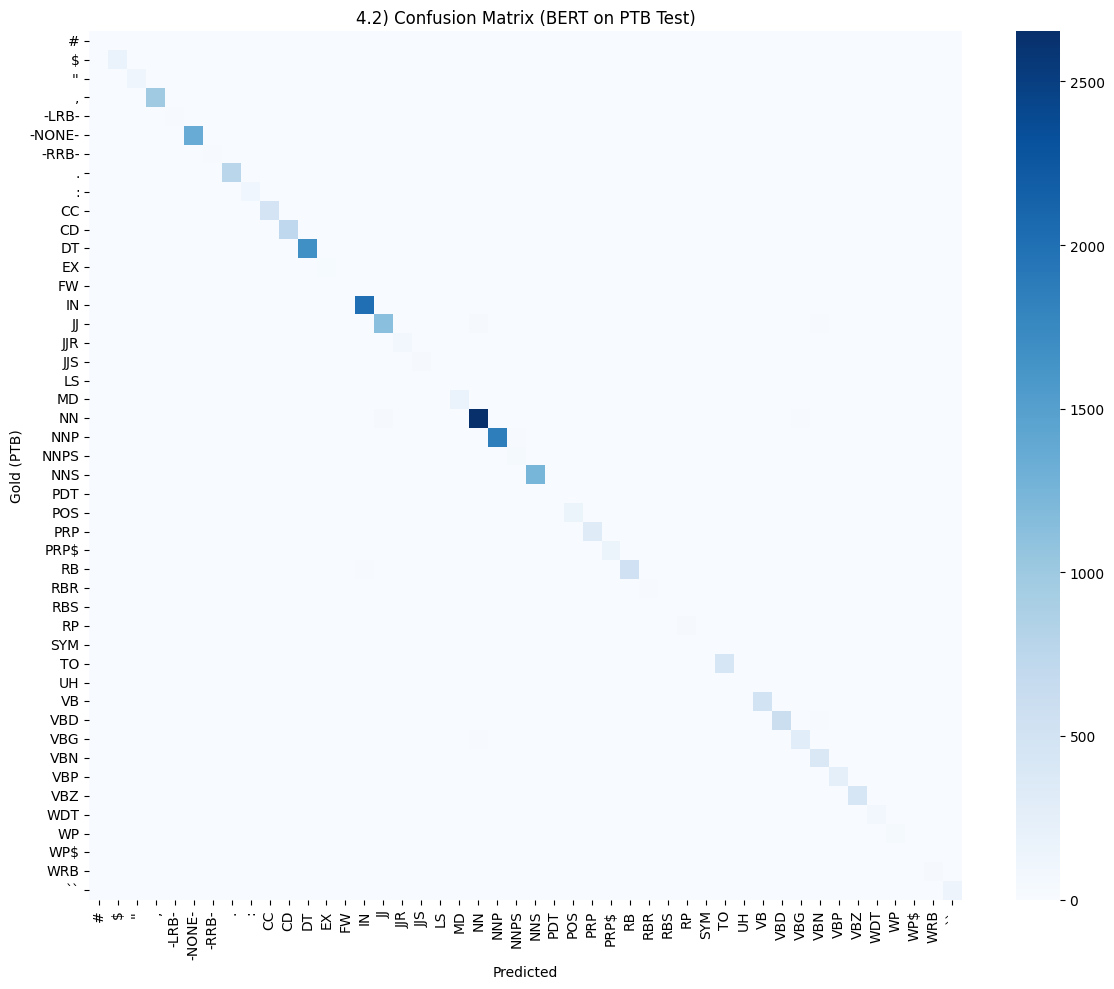


[Top 20 confusions: Gold(PTB) vs Predicted(BERT)]


,gold,pred,count
36,NN,JJ,36
21,JJ,NN,33
27,JJ,VBN,20
62,RB,IN,20
47,NNP,NNPS,19
41,NN,VBG,14
75,VBD,VBN,13
79,VBG,NN,12
14,IN,RB,10
46,NNP,NN,9


In [ ]:
if "cord_full_df" not in globals() or "cord_full_df" is None or len(cord_full_df) == 0:
    print("Please run Section 9 first.")
elif "cord_filt_df" not in globals() or cord_filt_df is None or len(cord_filt_df) == 0:
    print("Please run Section 10 first.")
else:
    low_conf_threshold = 0.60

    def tag_entropy(tags):
        p = pd.Series(tags).value_counts(normalize=True)
        return float(-(p * np.log2(p + 1e-12)).sum()) if len(p) > 0 else np.nan

    final_eval = pd.DataFrame([
        {
            "dataset": "A_full",
            "tokens": len(cord_full_df),
            "vocab_size": int(cord_full_df["filter_key"].nunique()),
            "avg_conf": float(cord_full_df["conf"].mean()),
            "low_conf_rate": float((cord_full_df["conf"] < low_conf_threshold).mean()),
            "tag_entropy": tag_entropy(cord_full_df["pred_tag"]),
        },
        {
            "dataset": "B_filtered",
            "tokens": len(cord_filt_df),
            "vocab_size": int(cord_filt_df["filter_key"].nunique()),
            "avg_conf": float(cord_filt_df["conf"].mean()),
            "low_conf_rate": float((cord_filt_df["conf"] < low_conf_threshold).mean()),
            "tag_entropy": tag_entropy(cord_filt_df["pred_tag"]),
        },
    ])

    print("[Section 11 Final evaluation table]")
    display(final_eval.style.format({"avg_conf": "{:.4f}", "low_conf_rate": "{:.4f}", "tag_entropy": "{:.4f}"}))

    if "all_preds" not in globals() or "all_labels" not in globals() or len(all_preds) == 0:
        all_preds, all_labels = [], []
        model.eval()
        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Evaluating (rebuild for confusion matrix)"):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"]
                logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
                preds = logits.argmax(-1).cpu()
                mask = labels != -100
                all_preds.extend(preds[mask].numpy().tolist())
                all_labels.extend(labels[mask].numpy().tolist())

    label_ids = sorted(id2label.keys())
    label_names = [id2label[i] for i in label_ids]
    cm = confusion_matrix(all_labels, all_preds, labels=label_ids).astype(float)
    cm_df = pd.DataFrame(cm, index=label_names, columns=label_names)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_df, cmap="Blues", cbar=True)
    plt.title("4.2) Confusion Matrix (BERT on PTB Test)")
    plt.xlabel("Predicted")
    plt.ylabel("Gold (PTB)")
    plt.tight_layout()
    plt.show()

    cm_offdiag = cm.copy()
    np.fill_diagonal(cm_offdiag, 0)
    pairs = []
    for i, gold_tag in enumerate(label_names):
        for j, pred_tag in enumerate(label_names):
            c = int(cm_offdiag[i, j])
            if c > 0:
                pairs.append({"gold": gold_tag, "pred": pred_tag, "count": c})

    if pairs:
        top_confusions_df = pd.DataFrame(pairs).sort_values("count", ascending=False).head(20)
        print("\n[Top 20 confusions: Gold(PTB) vs Predicted(BERT)]")
        display(top_confusions_df)
    else:
        print("No confusion pairs found.")

## 5. Additional Analyses 

Run additional analyses beyond raw vs filtered comparison.

- Morphological pattern analysis (digit / hyphen / uppercase / length)
- Confidence calibration (bin-wise confidence vs accuracy)
- Interpretation points

This section focuses on model behavior and confidence characteristics instead of difficult-case breakdown.

Pattern/Calibration analysis: 100%|██████████| 783/783 [00:28<00:00, 27.91it/s]


[Performance by morphological pattern]


,group,tokens,accuracy,avg_conf
9,len:>12,233,0.8798,0.9558
8,len:8-12,2859,0.9601,0.9816
2,has_hyphen=True,1102,0.9664,0.9807
7,len:4-7,8001,0.9783,0.9883
1,has_digit=False,19028,0.9806,0.9898
5,is_upper=False,19764,0.9816,0.9903
3,has_hyphen=False,19430,0.9826,0.9908
4,is_upper=True,768,0.9844,0.9892
6,len:len<=3,9439,0.9936,0.9954
0,has_digit=True,1504,0.9960,0.9958


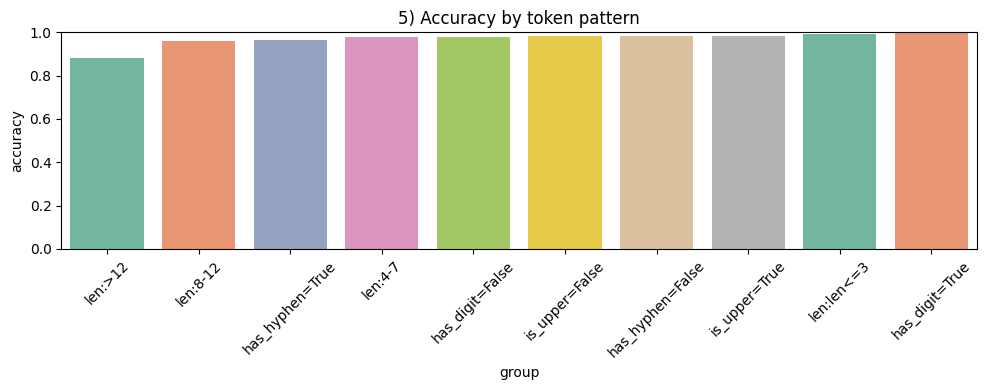


[Confidence calibration table]


,conf_bin,bin_count,bin_acc,bin_conf
0,"(-0.001, 0.1]",0,nan,nan
1,"(0.1, 0.2]",0,nan,nan
2,"(0.2, 0.3]",1,1.0000,0.2455
3,"(0.3, 0.4]",5,0.4000,0.3757
4,"(0.4, 0.5]",22,0.4545,0.4630
5,"(0.5, 0.6]",77,0.6494,0.5531
6,"(0.6, 0.7]",88,0.6250,0.6490
7,"(0.7, 0.8]",126,0.6111,0.7509
8,"(0.8, 0.9]",171,0.6082,0.8556
9,"(0.9, 1.0]",20042,0.9908,0.9968


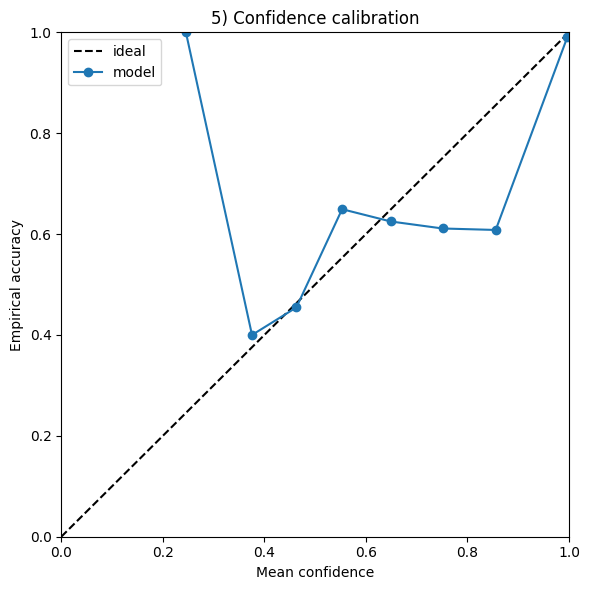

In [19]:
rows = []
model.eval()
for row in tqdm(test_data, desc="Pattern/Calibration analysis"):
    words = row["tokens"]
    true_ids = row["pos_tags"]

    if not words:
        continue

    encoding = tokenizer(
        words,
        is_split_into_words=True,
        return_offsets_mapping=False,
        max_length=MAX_LEN,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )
    word_ids = encoding.word_ids()

    with torch.no_grad():
        logits = model(
            input_ids=encoding["input_ids"].to(device),
            attention_mask=encoding["attention_mask"].to(device),
        ).logits[0].cpu()

    probs = torch.softmax(logits, dim=-1)
    pred_ids = logits.argmax(-1).tolist()
    max_probs = probs.max(dim=-1).values.tolist()

    prev_id = None
    idx_word = -1
    for idx, wid in enumerate(word_ids):
        if wid is not None and wid != prev_id:
            idx_word += 1
            if idx_word >= len(true_ids):
                continue
            token = str(words[idx_word])
            true_id = int(true_ids[idx_word])
            pred_id = int(pred_ids[idx])
            conf = float(max_probs[idx])

            rows.append({
                "token": token,
                "token_len": len(token),
                "has_digit": any(ch.isdigit() for ch in token),
                "has_hyphen": "-" in token,
                "is_upper": token.isupper() and len(token) >= 2,
                "true_id": true_id,
                "pred_id": pred_id,
                "conf": conf,
                "correct": int(true_id == pred_id),
            })
        prev_id = wid

analysis_df = pd.DataFrame(rows)
if len(analysis_df) == 0:
    print("No analyzable tokens found.")
else:
    pattern_rows = []
    for col in ["has_digit", "has_hyphen", "is_upper"]:
        for val, name in [(True, f"{col}=True"), (False, f"{col}=False")]:
            sub = analysis_df[analysis_df[col] == val]
            if len(sub) == 0:
                continue
            pattern_rows.append({
                "group": name,
                "tokens": len(sub),
                "accuracy": sub["correct"].mean(),
                "avg_conf": sub["conf"].mean(),
            })

    bins = [0, 3, 7, 12, 100]
    labels = ["len<=3", "4-7", "8-12", ">12"]
    analysis_df["len_bucket"] = pd.cut(analysis_df["token_len"], bins=bins, labels=labels, include_lowest=True)
    for b in labels:
        sub = analysis_df[analysis_df["len_bucket"] == b]
        if len(sub) == 0:
            continue
        pattern_rows.append({
            "group": f"len:{b}",
            "tokens": len(sub),
            "accuracy": sub["correct"].mean(),
            "avg_conf": sub["conf"].mean(),
        })

    pattern_df = pd.DataFrame(pattern_rows).sort_values("accuracy")
    print("[Performance by morphological pattern]")
    display(pattern_df.style.format({"accuracy": "{:.4f}", "avg_conf": "{:.4f}"}))

    plt.figure(figsize=(10, 4))
    sns.barplot(data=pattern_df, x="group", y="accuracy", hue="group", legend=False, palette="Set2")
    plt.title("5) Accuracy by token pattern")
    plt.xticks(rotation=45)
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.show()

    n_bins = 10
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    analysis_df["conf_bin"] = pd.cut(analysis_df["conf"], bins=bin_edges, include_lowest=True)

    calib_df = analysis_df.groupby("conf_bin", observed=False).agg(
        bin_count=("correct", "size"),
        bin_acc=("correct", "mean"),
        bin_conf=("conf", "mean"),
    ).reset_index()

    print("\n[Confidence calibration table]")
    display(calib_df.style.format({"bin_acc": "{:.4f}", "bin_conf": "{:.4f}"}))

    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], "k--", label="ideal")
    plt.plot(calib_df["bin_conf"], calib_df["bin_acc"], marker="o", label="model")
    plt.xlabel("Mean confidence")
    plt.ylabel("Empirical accuracy")
    plt.title("5) Confidence calibration")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

### 5.1 Raw vs Filtered Comparison (Proxy Evaluation)

Because CORD-19 has no gold labels, use full vs filtered prediction comparison as proxy analysis.

Compared items: evaluation table, distribution plots, confusion matrix (full-context prediction vs filtered-context prediction)

[Evaluation table - proxy]


,dataset,tokens,vocab_size,avg_conf,low_conf_rate,tag_entropy
0,A_full,986891,49376,0.9624,0.0354,3.7361
1,B_filtered,904122,22801,0.9627,0.0344,3.7324
2,A_full_on_filtered_tokens,903947,22800,0.9633,0.0339,3.7296
3,B_filtered_on_filtered_tokens,903947,22800,0.9627,0.0343,3.7324


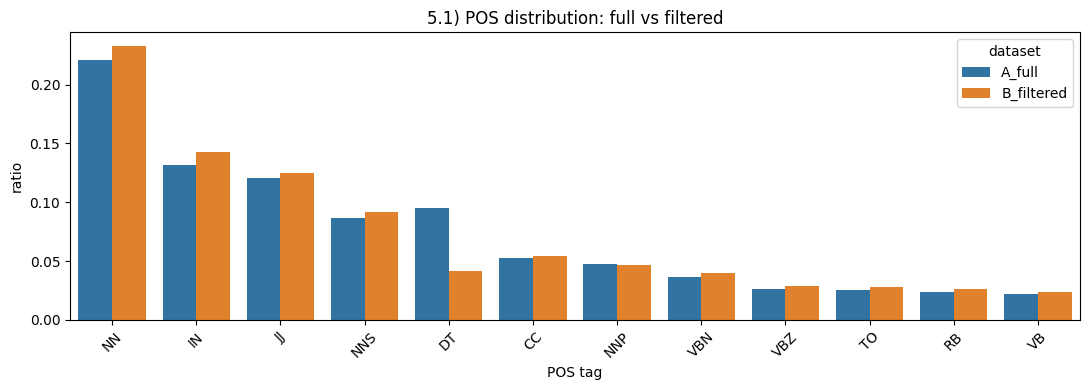

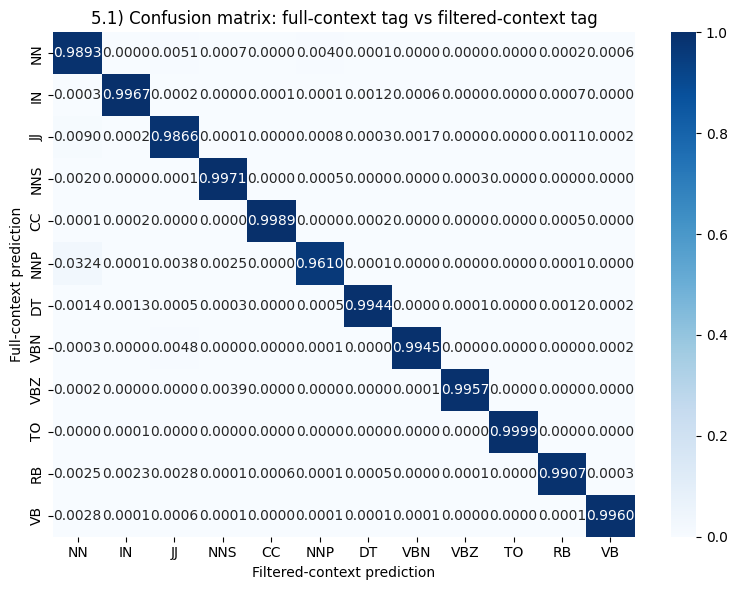

Tag agreement on aligned filtered tokens: 0.9877

[Difficult-region summary]
hard tokens: 40763 / 903947 (0.0451)
hard definition: tag mismatch or low confidence (conf < 0.6)

[Why difficult - feature uplift]


,feature,all_rate,hard_rate,uplift(hard-all)
4,is_rare_token,0.2008,0.4168,0.2160
1,has_digit,0.0366,0.2252,0.1886
2,has_hyphen,0.0313,0.2020,0.1707
3,is_upper_abbr,0.0070,0.0224,0.0155
0,is_long,0.0506,0.0398,-0.0108



[30 difficult-token examples]


,doc_id,orig_idx,token,token_norm,token_freq,pred_tag_full,pred_tag_filt,conf_full,conf_filt,agree,low_conf
761967,16857,5,dan,dan,57,VBD,JJ,0.063801,0.071131,False,True
84055,1852,5,dan,dan,57,VBD,NN,0.069741,0.101668,False,True
271867,6010,6,dan,dan,57,MD,VBD,0.073094,0.084786,False,True
403542,8926,28,es,es,41,DT,VBZ,0.083807,0.182927,False,True
271868,6010,9,dan,dan,57,MD,NN,0.085390,0.092433,False,True
465873,10305,0,WHAT,what,225,WP,VBZ,0.085556,0.094339,False,True
462865,10238,22,dan,dan,57,NN,VBD,0.086756,0.094503,False,True
36174,795,30,es,es,41,CC,NNS,0.087667,0.889859,False,True
462856,10238,5,dan,dan,57,VBD,NN,0.088993,0.081788,False,True
271893,6010,43,dan,dan,57,NN,VBD,0.090025,0.079708,False,True


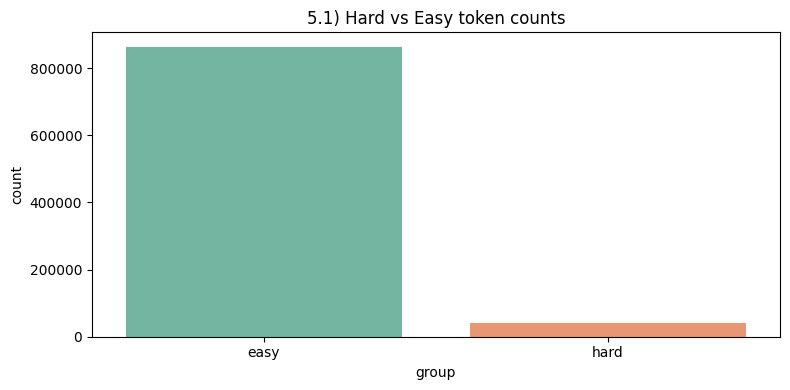

In [20]:
if metadata_df is None or len(metadata_df) == 0 or "abstract" not in metadata_df.columns:
    print("metadata_df is missing or has no abstract column. Please run the CORD-19 loading cell first.")
else:

    sample_size = 20000
    max_words_per_abs = 50
    min_token_freq = 2
    max_token_ratio = 0.05
    low_conf_threshold = 0.60
    random_state = 42

    valid_df = metadata_df[metadata_df["abstract"].notna() & (metadata_df["abstract"].str.len() > 0)].copy()
    if len(valid_df) == 0:
        print("No usable abstract available.")
    else:
        sample_df = valid_df.sample(n=min(sample_size, len(valid_df)), random_state=random_state)
        full_sentences = [str(t).split()[:max_words_per_abs] for t in sample_df["abstract"].tolist()]

        def norm_word(w):
            return re.sub(r"^[^a-z0-9]+|[^a-z0-9]+$", "", str(w).lower())

        all_norm_tokens = [norm_word(w) for sent in full_sentences for w in sent]
        all_norm_tokens = [t for t in all_norm_tokens if t]
        tok_counts = Counter(all_norm_tokens)
        max_token_freq = max(1, int(len(all_norm_tokens) * max_token_ratio))
        keep_tokens = {
            t for t, c in tok_counts.items()
            if c >= min_token_freq and c <= max_token_freq
        }

        filtered_sentences = []
        for sent in full_sentences:
            kept = [w for w in sent if norm_word(w) in keep_tokens]
            filtered_sentences.append(kept)

        def predict_pos_with_conf(sentences, model, tokenizer, id2label, device, max_length=128):
            model.eval()
            out_tags, out_conf = [], []

            for words in sentences:
                if not words:
                    out_tags.append([])
                    out_conf.append([])
                    continue

                encoding = tokenizer(
                    words,
                    is_split_into_words=True,
                    return_offsets_mapping=False,
                    max_length=max_length,
                    padding="max_length",
                    truncation=True,
                    return_tensors="pt",
                )
                word_ids = encoding.word_ids()

                with torch.no_grad():
                    logits = model(
                        input_ids=encoding["input_ids"].to(device),
                        attention_mask=encoding["attention_mask"].to(device),
                    ).logits[0].cpu()

                probs = torch.softmax(logits, dim=-1)
                pred_ids = logits.argmax(-1).tolist()
                max_probs = probs.max(dim=-1).values.tolist()

                prev_id = None
                tags = []
                confs = []
                for idx, wid in enumerate(word_ids):
                    if wid is not None and wid != prev_id:
                        tags.append(id2label.get(pred_ids[idx], "X"))
                        confs.append(float(max_probs[idx]))
                    prev_id = wid

                out_tags.append(tags)
                out_conf.append(confs)

            return out_tags, out_conf

        full_tags, full_conf = predict_pos_with_conf(full_sentences, model, tokenizer, id2label, device, max_length=MAX_LEN)
        filt_tags, filt_conf = predict_pos_with_conf(filtered_sentences, model, tokenizer, id2label, device, max_length=MAX_LEN)

        full_rows = []
        for doc_id, (sent, tags, confs) in enumerate(zip(full_sentences, full_tags, full_conf)):
            n = min(len(sent), len(tags), len(confs))
            for idx in range(n):
                full_rows.append({
                    "doc_id": doc_id,
                    "orig_idx": idx,
                    "token": sent[idx],
                    "token_norm": norm_word(sent[idx]),
                    "pred_tag_full": tags[idx],
                    "conf_full": confs[idx],
                })
        full_df = pd.DataFrame(full_rows)
        full_df = full_df[full_df["token_norm"].str.len() > 0].copy()

        filt_rows = []
        for doc_id, (sent, tags, confs) in enumerate(zip(filtered_sentences, filt_tags, filt_conf)):
            n = min(len(sent), len(tags), len(confs))
            for idx in range(n):
                filt_rows.append({
                    "doc_id": doc_id,
                    "kept_idx": idx,
                    "token": sent[idx],
                    "token_norm": norm_word(sent[idx]),
                    "pred_tag_filt": tags[idx],
                    "conf_filt": confs[idx],
                })
        filt_df = pd.DataFrame(filt_rows)
        filt_df = filt_df[filt_df["token_norm"].str.len() > 0].copy()

        full_kept_df = full_df[full_df["token_norm"].isin(keep_tokens)].copy()
        full_kept_df["kept_idx"] = full_kept_df.groupby("doc_id").cumcount()

        cmp_df = full_kept_df.merge(
            filt_df[["doc_id", "kept_idx", "token_norm", "pred_tag_filt", "conf_filt"]],
            on=["doc_id", "kept_idx", "token_norm"],
            how="inner",
        )

        cmp_df["agree"] = cmp_df["pred_tag_full"] == cmp_df["pred_tag_filt"]
        cmp_df["low_conf"] = (cmp_df["conf_full"] < low_conf_threshold) | (cmp_df["conf_filt"] < low_conf_threshold)
        cmp_df["hard"] = (~cmp_df["agree"]) | (cmp_df["low_conf"])
        cmp_df["token_freq"] = cmp_df["token_norm"].map(tok_counts).fillna(0).astype(int)

        def tag_entropy(tags):
            if len(tags) == 0:
                return np.nan
            p = pd.Series(tags).value_counts(normalize=True)
            return float(-(p * np.log2(p + 1e-12)).sum())

        def make_row(name, df, tag_col, conf_col):
            if len(df) == 0:
                return {
                    "dataset": name,
                    "tokens": 0,
                    "vocab_size": 0,
                    "avg_conf": np.nan,
                    "low_conf_rate": np.nan,
                    "tag_entropy": np.nan,
                }
            return {
                "dataset": name,
                "tokens": len(df),
                "vocab_size": int(df["token_norm"].nunique()),
                "avg_conf": float(df[conf_col].mean()),
                "low_conf_rate": float((df[conf_col] < low_conf_threshold).mean()),
                "tag_entropy": tag_entropy(df[tag_col]),
            }

        eval_df = pd.DataFrame([
            make_row("A_full", full_df, "pred_tag_full", "conf_full"),
            make_row("B_filtered", filt_df, "pred_tag_filt", "conf_filt"),
            make_row("A_full_on_filtered_tokens", cmp_df, "pred_tag_full", "conf_full"),
            make_row("B_filtered_on_filtered_tokens", cmp_df, "pred_tag_filt", "conf_filt"),
        ])

        print("[Evaluation table - proxy]")
        display(eval_df.style.format({
            "avg_conf": "{:.4f}",
            "low_conf_rate": "{:.4f}",
            "tag_entropy": "{:.4f}",
        }))

        dist_full = full_df["pred_tag_full"].value_counts(normalize=True)
        dist_filt = filt_df["pred_tag_filt"].value_counts(normalize=True)
        top_union = list((dist_full + dist_filt).sort_values(ascending=False).head(12).index)

        dist_plot = pd.DataFrame({
            "POS tag": top_union,
            "A_full": [dist_full.get(t, 0.0) for t in top_union],
            "B_filtered": [dist_filt.get(t, 0.0) for t in top_union],
        })
        dist_melt = dist_plot.melt(id_vars=["POS tag"], var_name="dataset", value_name="ratio")

        plt.figure(figsize=(11, 4))
        sns.barplot(data=dist_melt, x="POS tag", y="ratio", hue="dataset")
        plt.title("5.1) POS distribution: full vs filtered")
        plt.ylabel("ratio")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        if len(cmp_df) > 0:
            top_cm_tags = cmp_df["pred_tag_full"].value_counts().head(12).index.tolist()
            cm = confusion_matrix(cmp_df["pred_tag_full"], cmp_df["pred_tag_filt"], labels=top_cm_tags).astype(float)
            row_sum = cm.sum(axis=1, keepdims=True)
            cm_norm = np.divide(cm, row_sum, where=row_sum != 0)
            cm_df = pd.DataFrame(cm_norm, index=top_cm_tags, columns=top_cm_tags)

            plt.figure(figsize=(8, 6))
            sns.heatmap(cm_df, annot=True, fmt=".4f", cmap="Blues", vmin=0, vmax=1)
            plt.title("5.1) Confusion matrix: full-context tag vs filtered-context tag")
            plt.xlabel("Filtered-context prediction")
            plt.ylabel("Full-context prediction")
            plt.tight_layout()
            plt.show()

            print(f"Tag agreement on aligned filtered tokens: {cmp_df['agree'].mean():.4f}")
        else:
            print("No comparable tokens found; skipping confusion matrix.")

        if len(cmp_df) == 0:
            print("No comparison data available for difficult-region analysis.")
        else:
            hard_df = cmp_df[cmp_df["hard"]].copy()
            hard_rate = len(hard_df) / len(cmp_df)

            cmp_df["is_long"] = cmp_df["token_norm"].str.len() >= 12
            cmp_df["has_digit"] = cmp_df["token"].astype(str).str.contains(r"\d", regex=True)
            cmp_df["has_hyphen"] = cmp_df["token"].astype(str).str.contains(r"-", regex=False)
            cmp_df["is_upper_abbr"] = cmp_df["token"].astype(str).str.fullmatch(r"[A-Z]{2,6}").fillna(False)
            rare_cut = max(min_token_freq, int(np.percentile(cmp_df["token_freq"], 20)))
            cmp_df["is_rare_token"] = cmp_df["token_freq"] <= rare_cut

            reason_cols = ["is_long", "has_digit", "has_hyphen", "is_upper_abbr", "is_rare_token"]
            reason_rows = []
            for c in reason_cols:
                all_rate = float(cmp_df[c].mean())
                hard_cond = cmp_df[cmp_df["hard"]]
                hard_rate_cond = float(hard_cond[c].mean()) if len(hard_cond) > 0 else np.nan
                reason_rows.append({
                    "feature": c,
                    "all_rate": all_rate,
                    "hard_rate": hard_rate_cond,
                    "uplift(hard-all)": hard_rate_cond - all_rate if not np.isnan(hard_rate_cond) else np.nan,
                })
            reason_df = pd.DataFrame(reason_rows).sort_values("uplift(hard-all)", ascending=False)

            print("\n[Difficult-region summary]")
            print(f"hard tokens: {len(hard_df)} / {len(cmp_df)} ({hard_rate:.4f})")
            print(f"hard definition: tag mismatch or low confidence (conf < {low_conf_threshold})")

            print("\n[Why difficult - feature uplift]")
            display(reason_df.style.format({
                "all_rate": "{:.4f}",
                "hard_rate": "{:.4f}",
                "uplift(hard-all)": "{:.4f}",
            }))

            show_cols = [
                "doc_id", "orig_idx", "token", "token_norm", "token_freq",
                "pred_tag_full", "pred_tag_filt", "conf_full", "conf_filt", "agree", "low_conf"
            ]
            print("\n[30 difficult-token examples]")
            display(hard_df.sort_values(["agree", "conf_full", "conf_filt"], ascending=[True, True, True])[show_cols].head(30))

            plt.figure(figsize=(8, 4))
            hard_plot_df = pd.DataFrame({
                "group": ["easy", "hard"],
                "count": [int((~cmp_df["hard"]).sum()), int(cmp_df["hard"].sum())],
            })
            sns.barplot(data=hard_plot_df, x="group", y="count", hue="group", legend=False, palette="Set2")
            plt.title("5.1) Hard vs Easy token counts")
            plt.tight_layout()
            plt.show()

### 5.2 Results & Additional Analysis Summary

Summarize key metrics and additional analyses (morphological patterns, calibration) based on Sections 3-5.

In [21]:
if "final_eval" not in globals() or final_eval is None or len(final_eval) == 0:
    print("Please run Section 11 first to generate final_eval.")
else:
    display(final_eval.style.format({"avg_conf": "{:.4f}", "low_conf_rate": "{:.4f}", "tag_entropy": "{:.4f}"}))

    full_row = final_eval[final_eval["dataset"] == "A_full"]
    filt_row = final_eval[final_eval["dataset"] == "B_filtered"]

    if len(full_row) == 1 and len(filt_row) == 1:
        full_row = full_row.iloc[0]
        filt_row = filt_row.iloc[0]

        delta = pd.DataFrame([
            {"metric": "tokens", "full": float(full_row["tokens"]), "filtered": float(filt_row["tokens"]), "delta(filtered-full)": float(filt_row["tokens"] - full_row["tokens"])},
            {"metric": "avg_conf", "full": float(full_row["avg_conf"]), "filtered": float(filt_row["avg_conf"]), "delta(filtered-full)": float(filt_row["avg_conf"] - full_row["avg_conf"])},
            {"metric": "low_conf_rate", "full": float(full_row["low_conf_rate"]), "filtered": float(filt_row["low_conf_rate"]), "delta(filtered-full)": float(filt_row["low_conf_rate"] - full_row["low_conf_rate"])},
            {"metric": "tag_entropy", "full": float(full_row["tag_entropy"]), "filtered": float(filt_row["tag_entropy"]), "delta(filtered-full)": float(filt_row["tag_entropy"] - full_row["tag_entropy"])},
        ])

        print("[Main results: Full vs Filtered]")
        display(delta.style.format({"full": "{:.4f}", "filtered": "{:.4f}", "delta(filtered-full)": "{:.4f}"}))

if "pattern_df" in globals() and len(pattern_df) > 0:
    print("\n[Additional analysis summary: performance by morphological pattern]")
    display(pattern_df.sort_values("accuracy").head(10).style.format({"accuracy": "{:.4f}", "avg_conf": "{:.4f}"}))

if "calib_df" in globals() and len(calib_df) > 0:
    print("\n[Additional analysis summary: calibration]")
    display(calib_df.style.format({"bin_acc": "{:.4f}", "bin_conf": "{:.4f}"}))


,dataset,tokens,vocab_size,avg_conf,low_conf_rate,tag_entropy
0,A_full,1180376,55628,0.9621,0.0357,3.7477
1,B_filtered,812310,7626,0.9661,0.0297,3.6194


[Main results: Full vs Filtered]


,metric,full,filtered,delta(filtered-full)
0,tokens,1180376.0000,812310.0000,-368066.0000
1,avg_conf,0.9621,0.9661,0.0040
2,low_conf_rate,0.0357,0.0297,-0.0060
3,tag_entropy,3.7477,3.6194,-0.1283



[Additional analysis summary: performance by morphological pattern]


,group,tokens,accuracy,avg_conf
9,len:>12,233,0.8798,0.9558
8,len:8-12,2859,0.9601,0.9816
2,has_hyphen=True,1102,0.9664,0.9807
7,len:4-7,8001,0.9783,0.9883
1,has_digit=False,19028,0.9806,0.9898
5,is_upper=False,19764,0.9816,0.9903
3,has_hyphen=False,19430,0.9826,0.9908
4,is_upper=True,768,0.9844,0.9892
6,len:len<=3,9439,0.9936,0.9954
0,has_digit=True,1504,0.9960,0.9958



[Additional analysis summary: calibration]


,conf_bin,bin_count,bin_acc,bin_conf
0,"(-0.001, 0.1]",0,nan,nan
1,"(0.1, 0.2]",0,nan,nan
2,"(0.2, 0.3]",1,1.0000,0.2455
3,"(0.3, 0.4]",5,0.4000,0.3757
4,"(0.4, 0.5]",22,0.4545,0.4630
5,"(0.5, 0.6]",77,0.6494,0.5531
6,"(0.6, 0.7]",88,0.6250,0.6490
7,"(0.7, 0.8]",126,0.6111,0.7509
8,"(0.8, 0.9]",171,0.6082,0.8556
9,"(0.9, 1.0]",20042,0.9908,0.9968
